# Tracking maggots from videos in Imaris

In [1]:
%reload_ext XTIPython

You can now access BridgeLib, ImarisLib, vImaris, vDataSet, vScene and vFactory


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

## Loading a video and extracting the frames

Here we use FFMPeg to extract all the frames to a list and FFProbe to get a dictionary of all the movie's metadata.

In [3]:
from ipywidgets import FloatProgress
from IPython.display import display

import subprocess,sys,os,json

FFPROBE_BIN = "ffprobe.exe"
FFMPEG_BIN = "ffmpeg.exe"

def get_json_tags(fn):
    command = [ FFPROBE_BIN,'-v', 'error', '-count_frames', '-select_streams', 'v:0', \
            '-print_format', 'json',
            '-show_format', '-show_streams',
            fn]

    pipe = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    s = pipe.stdout.read().strip()
    dic = json.loads(s)
    return dic

def get_frames(fn,n_images=0,mod=1,grey=True,shape=(1080,1920)):
    size = shape[0]*shape[1]
    if grey:
        pix_fmt = 'gray'
    else:
        pix_fmt = 'rgb24'
        size *= 3
        shape = (shape[0],shape[1],3)
        
    command = [ FFMPEG_BIN,
            '-i', fn,
            '-f', 'image2pipe',
            '-pix_fmt', pix_fmt,
            '-vcodec', 'rawvideo', '-']
    if n_images == 0:
        n_images = get_nframes(fn)
        print(n_images)
        
    f = FloatProgress(min=0, max=n_images)
    display(f)
    
    pipe = subprocess.Popen(command, stdout=subprocess.PIPE, bufsize=10**8)    
    
    images = []
    for i in range(n_images):
        raw_image = pipe.stdout.read(size)
        f.value += 1

        if raw_image == '':
            break
        if i%mod != 0:
            continue
            
        image = np.fromstring(raw_image,dtype='uint8').reshape(*shape)
        images.append(image)
    return images

In [4]:
fn = r"D:\Data\Madison\maggots\CHEMO 1 VID BOTTOM RIGHT.mpg"

dic = get_json_tags(fn)
dic_stream = dic['streams'][0]

shape = (int(dic_stream['height']),int(dic_stream['width']))
n_frames = int(dic_stream['nb_frames'])
duration = float(dic_stream['duration'])

#You can access the following tags in streams[0]:
#print ", ".join(dic['streams'][0].keys())

#exact frame rate not important, use duration and number of frames:
framerate = n_frames / duration

images = get_frames(fn,n_frames,shape=shape)

FloatProgress(value=0.0, max=432.0)

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


## Estimate the background

To estimate the background, we compute the average frame by averaging the intensities over time for each pixel. Median should work better, but mean is fine.

In [5]:
background = np.mean(images,axis=0)

## Maggots extraction
To extract the maggots, we perform two steps: Subtracting the estimated background image from each frame, then smooth the result to help the tracking.

**Decision time!** Are the maggots brighter or darker than the background? Because we can't just subtract the background without knowing this. Unless... we take the absolute value of the result! But you know whether the maggots are brighter or darker than the background, you may as well use the info, otherwise, the absolute value may reveal false positive blobs:

  * **Brighter than the background:** output = frame - background
  * **Darker than the background:** output = background - frame
  * **Unknown or varies:** output = abs(frame-background)
  
Let's use the absolute value here:

In [6]:
foreground = np.abs(images[0]-background, dtype=np.float32)

An additional step (not absolutely required) is to filter the images. We shall boost the intensity range and threshold the output while we're at it. Here we use the libatrous library with the Linear 3x3 filter.

We must keep the final range in check, so for an 8 bit image (which the video was to begin with), we want to make sure the values are between 0 and 255.

In [7]:
import libatrous

threshold = 10
gain = 4

kernel = libatrous.get_kernel(libatrous.LIN3)
filtered = libatrous.get_bandpass(foreground,2,4,kernel)
#threshold!
filtered[filtered < threshold] = threshold
#boost!
filtered *= gain
filtered[filtered > 255] = 255

Let's see what we have:

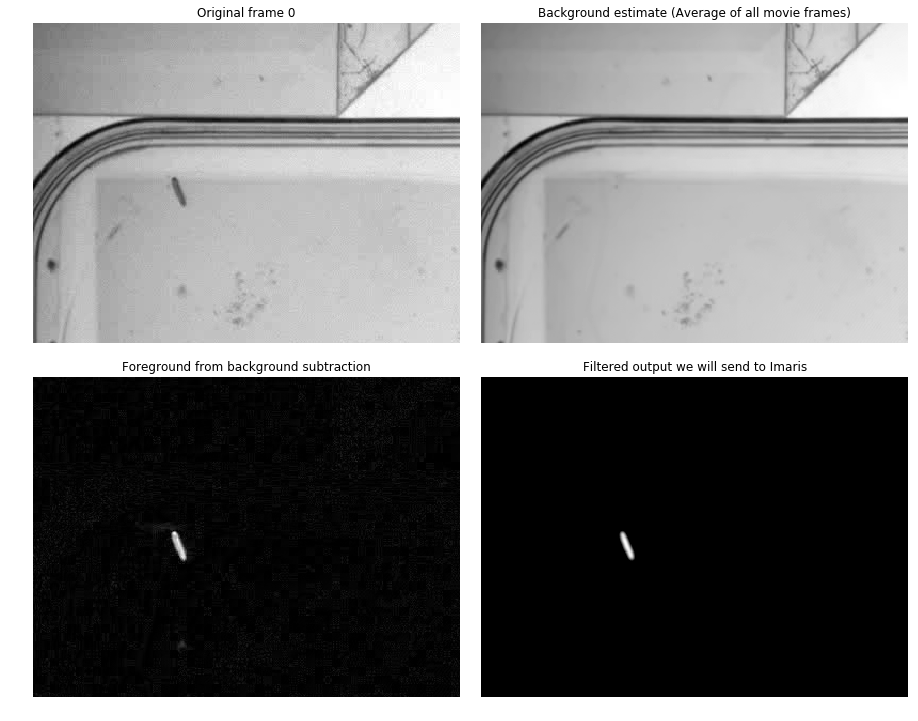

In [8]:
mpl.rcParams['figure.figsize'] = (18.0, 12.0)
fig, axis = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace=0.05, hspace=0.05)

ax = axis[0,0]
ax.imshow(images[0][:300,:400],cmap='gray')
ax.set_axis_off()
t = ax.set_title("Original frame 0")

ax = axis[0,1]
ax.imshow(background[:300,:400],cmap='gray')
ax.set_axis_off()
t = ax.set_title("Background estimate (Average of all movie frames)")

ax = axis[1,0]
ax.imshow(foreground[:300,:400],cmap='gray')
ax.set_axis_off()
t = ax.set_title("Foreground from background subtraction")

ax = axis[1,1]
ax.imshow(filtered[:300,:400],cmap='gray')
ax.set_axis_off()
t = ax.set_title("Filtered output we will send to Imaris")


Let's do this for all the frames in the movie. Maggots tend not to move too fast, so we don't actually need all the frames. 1 in 5 is going to be more than enough in this case.

In [9]:
skip_factor = 5
threshold = 10
gain = 4

kernel = libatrous.get_kernel(libatrous.LIN3)

output = []

n_images = len(images)

# Progress bar
f = FloatProgress(min=0, max=n_images/skip_factor)
display(f)
    
for i in range(0,n_images/skip_factor):
    foreground = np.abs(images[i*skip_factor]-background, dtype=np.float32)
    filtered = libatrous.get_bandpass(foreground,2,4,kernel)

    #threshold!
    filtered[filtered < threshold] = 0
    #boost!
    filtered *= gain
    filtered[filtered > 255] = 255

    output.append(filtered)
    f.value += 1

FloatProgress(value=0.0, max=86.0)

Reality check... what does the filtered stack look like?

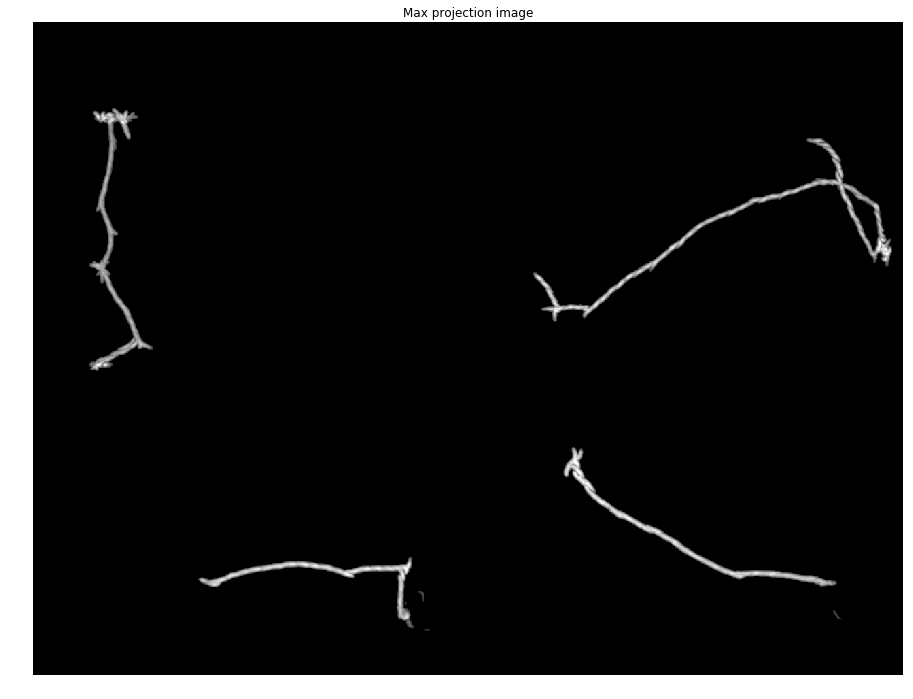

In [10]:
tracks = np.max(output,axis=0)
fig, ax = plt.subplots(1,1)

ax.imshow(tracks,cmap='gray')
ax.set_axis_off()
t = ax.set_title("Max projection image")

# Sending the processed movie to Imaris

We need to create a scene, add a frame and a light source, then create a suitable dataset, then attach it to vImaris.

The pixel resolution / time resolution also need to be set properly. We measure the maggot (30 pixels = 3mm, aka gross assumption) and the frame to frame time interval is measured from the framerate (multiplied by the skip factor). 

In [11]:
import time

%load_ext autoreload
%autoreload 2

vSurpassScene = vImaris.GetSurpassScene()
vFactory = vImaris.GetFactory() #Actually, we already have access to vFactory, but here's how you could re-create it.

if vSurpassScene is None:
    print("No Scene, let's create one!")
    vSurpassScene = vFactory.CreateDataContainer()
    vSurpassScene.SetName('Scene')

    vLightSource = vFactory.CreateLightSource()
    vLightSource.SetName('Light Source 1');
    vSurpassScene.AddChild(vLightSource,-1)

    vFrame = vFactory.CreateFrame()
    vFrame.SetName('Frame 1')
    vSurpassScene.AddChild(vFrame,-1)

    vImaris.SetSurpassScene(vSurpassScene);

#Now create a new dataset
print("Let's upload some frames!")

n_output = len(output)
h,w = output[0].shape

# Progress bar for iPython
f = FloatProgress(min=0, max=n_output)
display(f)

vDataSet = vFactory.CreateDataSet()
vDataSet.Create(vDataSet.GetType(),w,h,1,1,n_output)

#Now set the XYZ extent (assume 100um / pixel (3mm maggot = 30 pixels length))
BridgeLib.SetExtent(vDataSet,[0,w*100,0,h*100,0,1])

t0 = time.time()
tdelta = skip_factor / framerate
vDataSet.SetTimePointsDelta(tdelta)

for i in range(n_output):
    #These are 2-D images, so use SetDataSlice. Channel 0. All that's varying is the timepoint
    BridgeLib.SetDataSlice(vDataSet,output[i],0,0,i)
    
    t = t0+i*tdelta
    s = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(t))+("%.3f" % (t-int(t)))[1:]
    vDataSet.SetTimePoint(i,s)

    f.value += 1

vImaris.SetDataSet(vDataSet)

No Scene, let's create one!
Let's upload some frames!


FloatProgress(value=0.0, max=86.0)

# Let's track the maggots!

In [13]:
vSurpassScene = vImaris.GetSurpassScene()
vFactory = vImaris.GetFactory() #Actually, we already have access to vFactory, but here's how you could re-create it.
vIP = vImaris.GetImageProcessing() #We also need vImageProcessing for this step (vIP)

#The surfaces. These parameters will work, might need adjusting though...
surf = vIP.DetectSurfaces(vDataSet,None,0,0,0,False,threshold,'"Volume" above automatic threshold')

#The tracks (again, these parameters work but may not be optimal)
surf = vIP.TrackSurfacesAutoregressiveMotion(surf,5000,3, '"Track Duration" above 2.50 s')

#Give the tracks a name and add them to the surpass scene
surf.SetName('Maggot Tracks')
vSurpassScene.AddChild(surf,-1)

# Final result (for now)

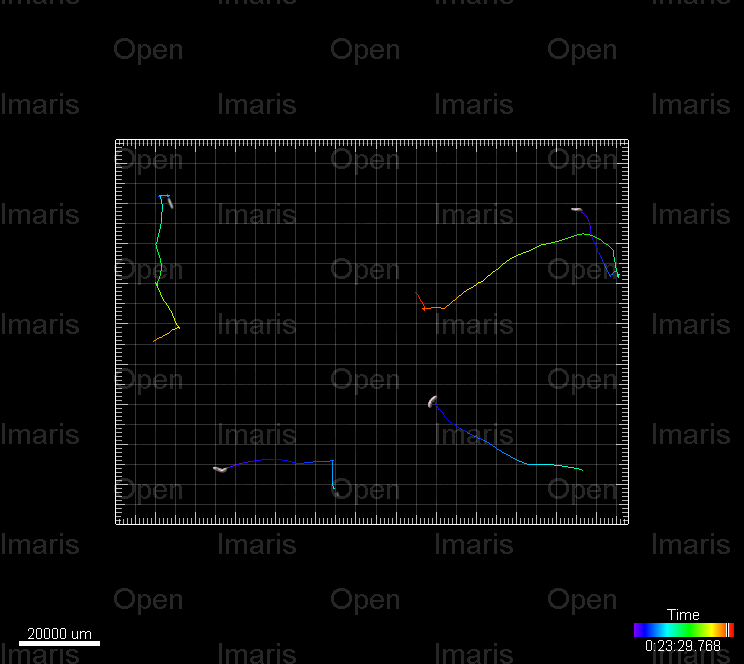

In [14]:
%imaris_screenshot